**Overview**
- **Purpose:** QC of spatially resolved transcriptomic data using a bioconductor package SpotSweeper
- **Author:** Tamim Ahsan
- **Date:** December 31, 2025

**Additional information:**
- SpotSweeper documentation (https://bioconductor.org/packages//release/bioc/vignettes/SpotSweeper/inst/doc/getting_started.html) was followed
- A single DLPFC 10x Visium dataset was analysed  

# 1. Install and load packages

In [1]:
# Install packages
install.packages("BiocManager") # install biocmanager so that bioconductor packages can be installed
system("apt-get install libmagick++-dev") # necessary for installing the R package "magick", which is needed by SpotSweeper
BiocManager::install("SpotSweeper") # install SpotSweeper package itself
BiocManager::install("STexampleData") # necessary for downloading example datasets
BiocManager::install("scuttle") # for adding QC metrics per spot

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'BiocVersion', 'SpotSweeper'

also installing the dependencies ‘proxy’, ‘plogr’, ‘XVector’, ‘e1071’, ‘wk’, ‘formatR’, ‘RSQLite’, ‘filelock’, ‘matrixStats’, ‘abind’, ‘SparseArray’, ‘classInt’, ‘s2’, ‘units’, ‘lambda.r’, ‘futile.options’, ‘rjson’, ‘magick’, ‘S4Vectors’, ‘BiocGenerics’, ‘BiocFileCache’, ‘MatrixGenerics’, ‘GenomicRanges’, ‘Biobase’, ‘IRanges’, ‘Seqinfo’, ‘S4Arrays’, ‘DelayedArray’, ‘assorthead’, ‘sf’, ‘terra’, ‘futile.logger’, ‘snow’, ‘BH’, ‘SpatialExperiment’, ‘SummarizedExperiment’, ‘BiocNeighbors’, ‘SingleCellExperiment’, ‘escheR’, ‘spatialEco’, ‘BiocParallel’


Old packages: 'data.table', 'knitr', 'selectr'

In [2]:
# Load packages
library(tidyverse)
library(SpotSweeper)
library(scuttle)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCu

# 2. Download and explore the dataset

In [3]:
# Load example data
spe <- STexampleData::Visium_humanDLPFC() # a single sample (sample 151673) is loaded
spe # this is a SpatialExperiment object

see ?STexampleData and browseVignettes('STexampleData') for documentation

downloading 1 resources

retrieving 1 resource



loading from cache



class: SpatialExperiment 
dim: 33538 4992 
metadata(0):
assays(1): counts
rownames(33538): ENSG00000243485 ENSG00000237613 ... ENSG00000277475
  ENSG00000268674
rowData names(3): gene_id gene_name feature_type
colnames(4992): AAACAACGAATAGTTC-1 AAACAAGTATCTCCCA-1 ...
  TTGTTTGTATTACACG-1 TTGTTTGTGTAAATTC-1
colData names(8): barcode_id sample_id ... reference cell_count
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : pxl_col_in_fullres pxl_row_in_fullres
imgData names(4): sample_id image_id data scaleFactor

In [4]:
# Dimensions
dim(spe)

[1] 33538  4992

In [5]:
# Available assays
assayNames(spe)

[1] "counts"

In [6]:
# Row data (gene-related metadata)
head(rowData(spe))

DataFrame with 6 rows and 3 columns
                        gene_id   gene_name    feature_type
                    <character> <character>     <character>
ENSG00000243485 ENSG00000243485 MIR1302-2HG Gene Expression
ENSG00000237613 ENSG00000237613     FAM138A Gene Expression
ENSG00000186092 ENSG00000186092       OR4F5 Gene Expression
ENSG00000238009 ENSG00000238009  AL627309.1 Gene Expression
ENSG00000239945 ENSG00000239945  AL627309.3 Gene Expression
ENSG00000239906 ENSG00000239906  AL627309.2 Gene Expression

In [7]:
# Column data (sample-related metadata)
head(colData(spe))

DataFrame with 6 rows and 8 columns
                           barcode_id     sample_id in_tissue array_row
                          <character>   <character> <integer> <integer>
AAACAACGAATAGTTC-1 AAACAACGAATAGTTC-1 sample_151673         0         0
AAACAAGTATCTCCCA-1 AAACAAGTATCTCCCA-1 sample_151673         1        50
AAACAATCTACTAGCA-1 AAACAATCTACTAGCA-1 sample_151673         1         3
AAACACCAATAACTGC-1 AAACACCAATAACTGC-1 sample_151673         1        59
AAACAGAGCGACTCCT-1 AAACAGAGCGACTCCT-1 sample_151673         1        14
AAACAGCTTTCAGAAG-1 AAACAGCTTTCAGAAG-1 sample_151673         1        43
                   array_col ground_truth   reference cell_count
                   <integer>  <character> <character>  <integer>
AAACAACGAATAGTTC-1        16           NA          NA         NA
AAACAAGTATCTCCCA-1       102       Layer3      Layer3          6
AAACAATCTACTAGCA-1        43       Layer1      Layer1         16
AAACACCAATAACTGC-1        19           WM          WM          

In [8]:
# Spatial coordinates
head(spatialCoords(spe))

,pxl_col_in_fullres,pxl_row_in_fullres
AAACAACGAATAGTTC-1,3913,2435
AAACAAGTATCTCCCA-1,9791,8468
AAACAATCTACTAGCA-1,5769,2807
AAACACCAATAACTGC-1,4068,9505
AAACAGAGCGACTCCT-1,9271,4151
AAACAGCTTTCAGAAG-1,3393,7583


In [9]:
# Image data
imgData(spe)

DataFrame with 2 rows and 4 columns
      sample_id    image_id   data scaleFactor
    <character> <character> <list>   <numeric>
1 sample_151673      lowres   ####   0.0450045
2 sample_151673       hires   ####   0.1500150

In [10]:
# Column names of the sample-related metadata
colnames(colData(spe))

[1] "barcode_id"   "sample_id"    "in_tissue"    "array_row"    "array_col"   
[6] "ground_truth" "reference"    "cell_count"

In [11]:
# Keep only the spots that fall under the tissue
# Such spots would have in_tissue value of 1
print(paste0("The number of spots before filtering = ", nrow(spe)))
spe <- spe[, spe$in_tissue == 1]
print(paste0("The number of spots after filtering = ", nrow(spe)))

[1] "The number of spots before filtering = 33538"
[1] "The number of spots after filtering = 33538"


# 3. Calculate QC metrics with scuttle
scuttle was created for single-cell/single-nucleus RNA-seq data

In [12]:
# Look at the column names of gene-related metadata
colnames(rowData(spe))

[1] "gene_id"      "gene_name"    "feature_type"

In [13]:
rownames(spe) <- rowData(spe)$gene_name # set gene-name as the rownames
is.mito <- rownames(spe)[grepl("^MT-", rownames(spe))] # list mitochondrial genes

In [14]:
# Add per-cell (per-spot, in this case) QC metrics values to the spe object
spe <- scuttle::addPerCellQC(
  spe,
  subsets = list(Mito = is.mito)
)
colnames(colData(spe)) # check the names of the newly added columns

[1] "barcode_id"            "sample_id"             "in_tissue"            
 [4] "array_row"             "array_col"             "ground_truth"         
 [7] "reference"             "cell_count"            "sum"                  
[10] "detected"              "subsets_Mito_sum"      "subsets_Mito_detected"
[13] "subsets_Mito_percent"  "total"

# 4. Identify local outliers

In [15]:
# Local outlier detection -
# based on library size
spe <- localOutliers(
  spe,
  metric = "sum", # library size
  direction = "lower", # lower than a certain value (value of the metic - 3*z_score)
  log = TRUE, # log1p transformation is done
  n_neighbors = 36
)

# based on the number of detected genes
spe <- localOutliers(
  spe,
  metric = "detected",
  direction = "lower",
  log = TRUE,
  n_neighbors = 36
)

# based on the percentage of reads mapped to mitochondrial genes
spe <- localOutliers(
  spe,
  metric = "subsets_Mito_percent",
  direction = "higher",
  log = FALSE,
  n_neighbors = 36
)

In [16]:
# New columns x_outliers have been added the to the colData
colnames(colData(spe))

[1] "barcode_id"                    "sample_id"                    
 [3] "in_tissue"                     "array_row"                    
 [5] "array_col"                     "ground_truth"                 
 [7] "reference"                     "cell_count"                   
 [9] "sum"                           "detected"                     
[11] "subsets_Mito_sum"              "subsets_Mito_detected"        
[13] "subsets_Mito_percent"          "total"                        
[15] "sum_log"                       "sum_outliers"                 
[17] "sum_z"                         "detected_log"                 
[19] "detected_outliers"             "detected_z"                   
[21] "subsets_Mito_percent_outliers" "subsets_Mito_percent_z"

In [17]:
# Combine all the outliers into a single column
spe$local_outliers <- as.logical(spe$sum_outliers) |
  as.logical(spe$detected_outliers) |
  as.logical(spe$subsets_Mito_percent_outliers)
table(spe$local_outliers)


FALSE  TRUE 
 3628    11 

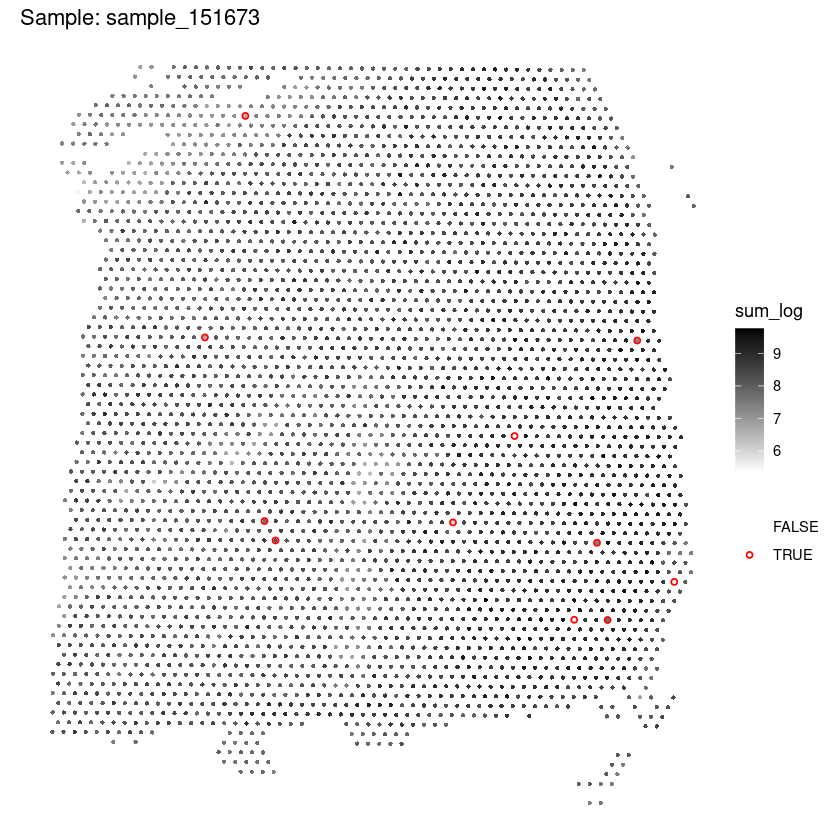

In [18]:
# Plot the outliers
plotQCmetrics(spe,
              metric = "sum_log",
              outliers = "local_outliers",
              point_size = 1.2,
              stroke = 0.75)

# 5. Identify technical artifacts

In [19]:
data(DLPFC_artifact) # example dataset for examining technical artifacts
spe <- DLPFC_artifact
spe

class: SpatialExperiment 
dim: 5000 3529 
metadata(0):
assays(1): counts
rownames(5000): ENSG00000131095 ENSG00000123560 ... ENSG00000105647
  ENSG00000213066
rowData names(7): source type ... gene_type gene_search
colnames(3529): AAACAACGAATAGTTC-1 AAACAAGTATCTCCCA-1 ...
  TTGTTTGTATTACACG-1 TTGTTTGTGTAAATTC-1
colData names(18): sample_id in_tissue ... count sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : pxl_col_in_fullres pxl_row_in_fullres
imgData names(1): sample_id

In [20]:
# Check the column names of the sample-related metadata
colnames(colData(spe))

[1] "sample_id"          "in_tissue"          "array_row"         
 [4] "array_col"          "key"                "sum_umi"           
 [7] "sum_gene"           "expr_chrM"          "expr_chrM_ratio"   
[10] "ManualAnnotation"   "subject"            "region"            
[13] "sex"                "age"                "diagnosis"         
[16] "sample_id_complete" "count"              "sizeFactor"

In [21]:
# Find aritifacts
spe <- findArtifacts(spe,
                     mito_percent = "expr_chrM_ratio",
                     mito_sum = "expr_chrM",
                     n_order = 5,
                     name = "artifact")
# Check the newly added columns
colnames(colData(spe))

[1] "sample_id"           "in_tissue"           "array_row"          
 [4] "array_col"           "key"                 "sum_umi"            
 [7] "sum_gene"            "expr_chrM"           "expr_chrM_ratio"    
[10] "ManualAnnotation"    "subject"             "region"             
[13] "sex"                 "age"                 "diagnosis"          
[16] "sample_id_complete"  "count"               "sizeFactor"         
[19] "expr_chrM_ratio_log" "coords"              "k6"                 
[22] "k18"                 "k36"                 "k60"                
[25] "k90"                 "artifact"

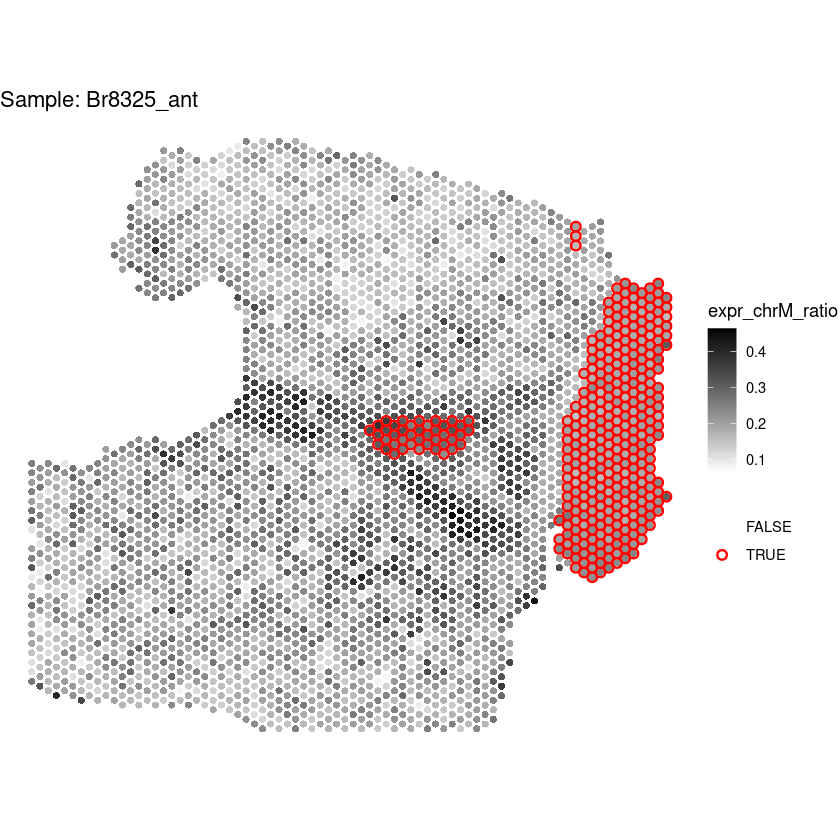

In [22]:
# Visualize hangnail artifacts
plotQCmetrics(
  spe,
  metric = "expr_chrM_ratio",
  outliers = "artifact",
  point_size = 2
)

In [23]:
sessionInfo()

R version 4.5.2 (2025-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] STexampleData_1.18.0        SpatialExperiment_1.20.0   
 [3] ExperimentHub_3.0.0         AnnotationHub_4.0.0        
 [5] BiocFileCache_3.0.0         dbplyr_2.5